# 랭체인(LangChain) SelfQueryRetriever hotel search 예제
## 작성자 : AISchool ( http://aischool.ai/%ec%98%a8%eb%9d%bc%ec%9d%b8-%ea%b0%95%ec%9d%98-%ec%b9%b4%ed%85%8c%ea%b3%a0%eb%a6%ac/ )
## Reference : https://github.com/langchain-ai/langchain/blob/master/cookbook/self_query_hotel_search.ipynb

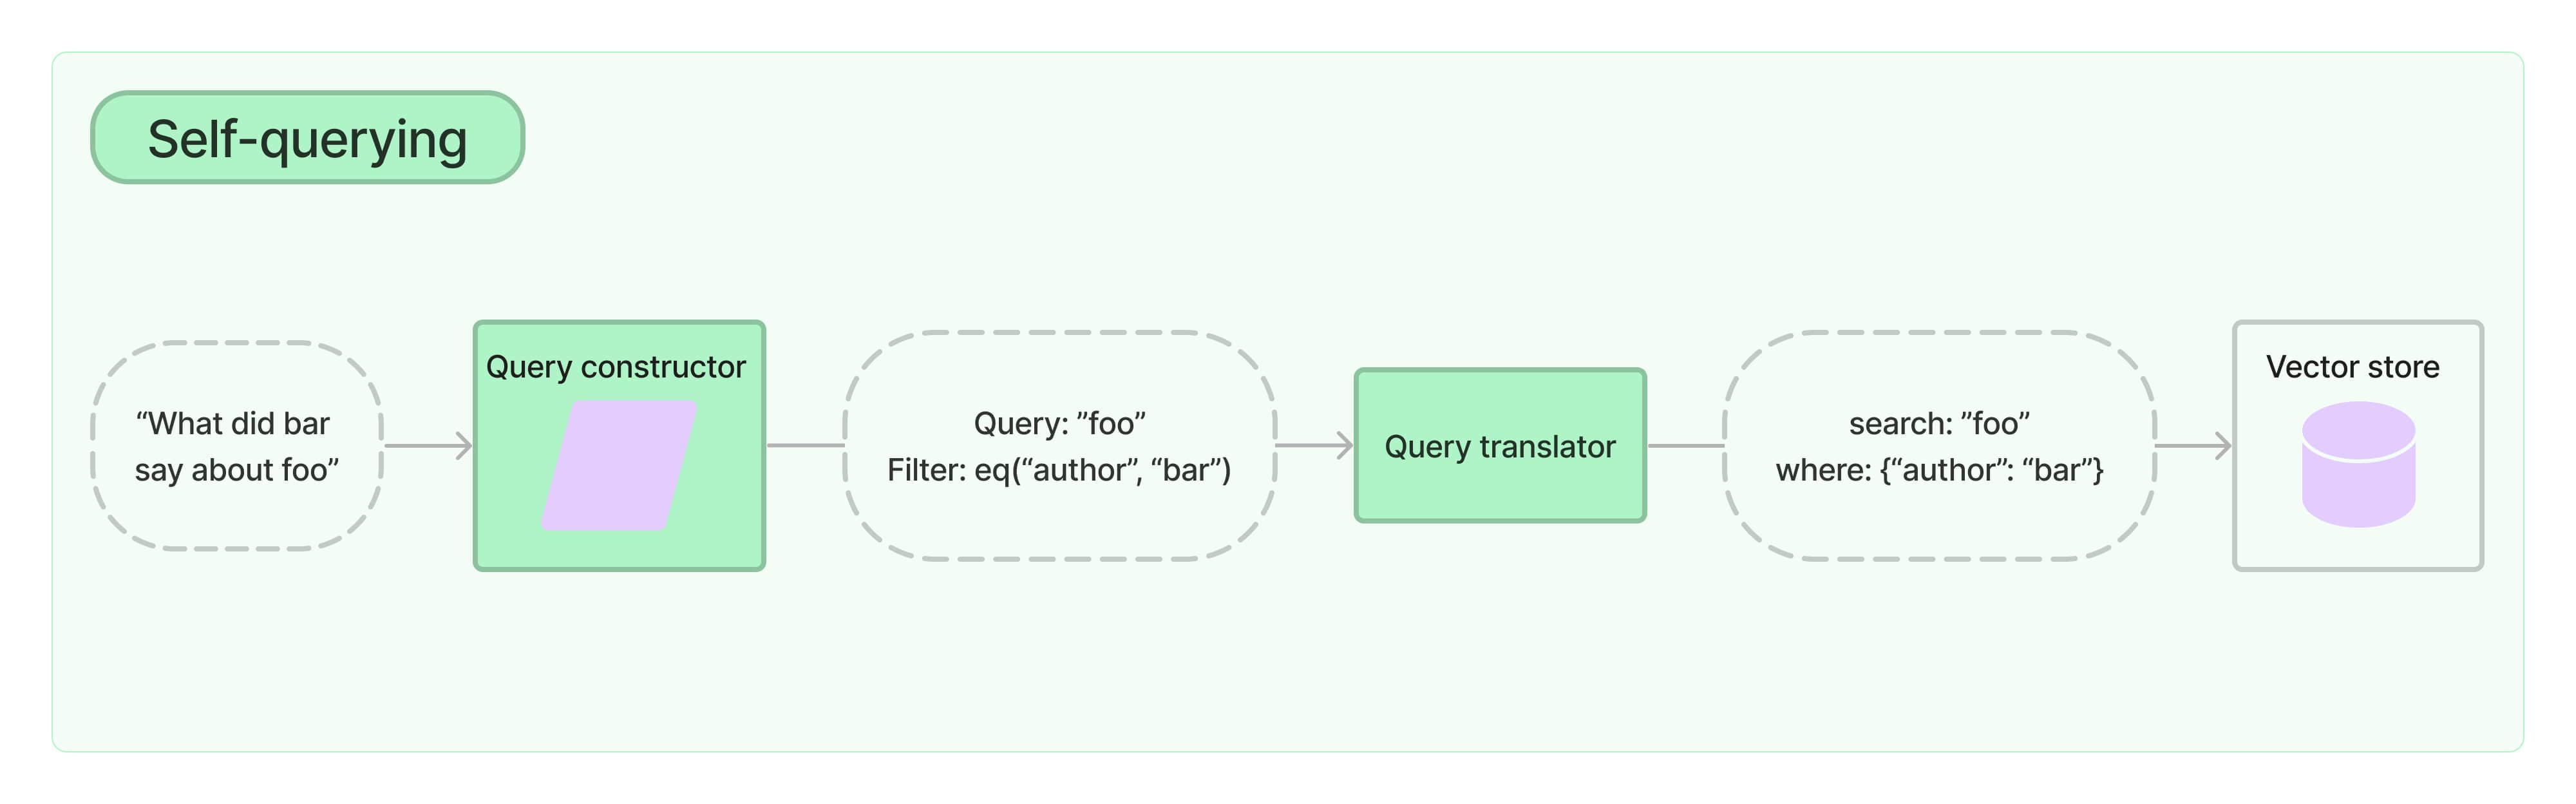

### SelfQueryRetriever를 이용해서 Hotel Search Application을 만들어봅시다.

## 데이터 다운로드 : https://www.kaggle.com/datasets/keshavramaiah/hotel-recommendation

In [ ]:
!unzip archive.zip

# LangChain 라이브러리 설치

In [ ]:
!pip install langchain lark openai pandas langchain-openai sentence-transformers chromadb

# Imports and data prep


In [ ]:
import pandas as pd

In [ ]:
details = (
    pd.read_csv("Hotel_details.csv")
    .drop_duplicates(subset="hotelid")
    .set_index("hotelid")
)
attributes = pd.read_csv(
    "Hotel_Room_attributes.csv", index_col="id"
)
price = pd.read_csv("hotels_RoomPrice.csv", index_col="id")

In [ ]:
details

,id,hotelname,address,city,country,zipcode,propertytype,starrating,latitude,longitude,Source,url,curr
hotelid,,,,,,,,,,,,,
1771651,46406,Mediteran Bungalow Galeb,Vukovarska 7,Omis,Croatia,21310.0,Holiday parks,4,43.440124,16.682505,2,https://www.booking.com/hotel/hr/bungalow-luxu...,EUR
177167,46407,Hotel Polonia,Plac Teatralny 5,Torun,Poland,NaN,Hotels,3,53.012329,18.603800,5,https://www.agoda.com/en-gb/hotel-polonia/hote...,EUR
1771675,46408,Rifugio Sass Bece,"Belvedere del Pordoi,1",Canazei,Italy,38032.0,Hotels,3,46.477920,11.813350,2,http://www.booking.com/hotel/it/rifugio-sass-b...,EUR
177168,46409,Madalena Hotel,Mykonos,Mykonos,Greece,84600.0,Hotels,3,37.452316,25.329849,5,https://www.agoda.com/en-gb/madalena-hotel/hot...,EUR
1771718,46410,Pension Morenfeld,Mair im Korn Strasse 2,Lagundo,Italy,39022.0,Hotels,3,46.682780,11.131736,2,http://www.booking.com/hotel/it/pension-morenf...,EUR
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1771620,154449,Hotel Stadt Tuttlingen,Donaustrasse 30,Tuttlingen,Germany,78532.0,Hotels,3,47.985364,8.817228,2,http://www.booking.com/hotel/de/stadt-tuttling...,EUR
1771626,154450,Hotel Beroe,15 Yasen Str.,Sveti Vlas,Bulgaria,8256.0,Hotels,3,42.710919,27.763325,2,http://www.booking.com/hotel/bg/beroe.en-gb.html,BGN
177163,154451,Hotel Rothmans,14 Ohrid Str.,Bansko,Bulgaria,2770.0,Hotels,3,41.837379,23.492391,2,http://www.booking.com/hotel/bg/rothmans-bansk...,BGN


In [ ]:
attributes

,hotelcode,roomamenities,roomtype,ratedescription
id,,,,
50677497,634876,Air conditioning: ;Alarm clock: ;Carpeting: ;C...,Double Room,"Room size: 15 m²/161 ft², Shower, 1 king bed"
50672149,8328096,Air conditioning: ;Closet: ;Fireplace: ;Free W...,Vacation Home,"Shower, Kitchenette, 2 bedrooms, 1 double bed ..."
50643430,8323442,Air conditioning: ;Closet: ;Dishwasher: ;Firep...,Vacation Home,"Shower, Kitchenette, 2 bedrooms, 1 double bed ..."
50650317,7975,Air conditioning: ;Clothes rack: ;Coffee/tea m...,Standard Triple Room,"Room size: 20 m²/215 ft², Shower, 3 single beds"
50650318,7975,Air conditioning: ;Clothes rack: ;Coffee/tea m...,Standard Triple Room,"Room size: 20 m²/215 ft², Shower, 3 single beds"
...,...,...,...,...
88527729,268416,Air conditioning: ;Alarm clock: ;Carpeting: ;C...,Twin Room,"Room size: 17 m²/183 ft², Non-smoking, Shower,..."
88527730,268416,Air conditioning: ;Alarm clock: ;Carpeting: ;C...,Twin Room,"Room size: 17 m²/183 ft², Non-smoking, Shower,..."
88527731,268416,Air conditioning: ;Alarm clock: ;Carpeting: ;C...,Twin Room,"Room size: 17 m²/183 ft², Non-smoking, Shower,..."


In [ ]:
price

,refid,hotelcode,websitecode,dtcollected,ratedate,los,guests,roomtype,onsiterate,netrate,...,promoname,status_code,taxstatus,taxtype,taxamount,proxyused,israteperstay,mealinclusiontype,hotelblock,input_dtcollected
id,,,,,,,,,,,,,,,,,,,,,
50677497,8646773,634876,5,2019-10-12 15:46:54,2019-11-02,1,1,Double Room,82.36,87.84,...,NaN,200,2,NaN,0.0,media:M3diAproxy@173.44.165.126:80,Y,Free Breakfast,NaN,2019-10-13
50672149,6234691,8328096,5,2019-10-12 15:47:45,2019-11-30,1,1,Vacation Home,636.09,0.00,...,NaN,200,2,NaN,0.0,media:M3diAproxy@173.44.164.126:80,Y,NaN,NaN,2019-10-13
50643430,7015677,8323442,5,2019-10-12 15:47:00,2019-12-20,1,1,Vacation Home,591.74,0.00,...,NaN,200,2,NaN,0.0,media:M3diAproxy@173.44.166.122:80,Y,NaN,NaN,2019-10-13
50650317,7327094,7975,5,2019-10-12 15:47:02,2019-12-28,1,1,Standard Triple Room,881.48,0.00,...,NaN,200,2,Tax 20%,0.0,media:M3diAproxy@209.242.219.141:80,Y,NaN,NaN,2019-10-13
50650318,7327094,7975,5,2019-10-12 15:47:02,2019-12-28,1,1,Standard Triple Room,897.53,0.00,...,NaN,200,2,VAT $ 179.51,0.0,media:M3diAproxy@209.242.219.141:80,Y,Free breakfast for {3},NaN,2019-10-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88527729,9572875,268416,5,2019-10-13 01:03:10,2019-11-26,1,1,Twin Room,81.83,0.00,...,NaN,200,2,VAT $ 16.37,0.0,media:M3diAproxy@173.44.166.122:80,Y,NaN,NaN,2019-10-13
88527730,9572875,268416,5,2019-10-13 01:03:10,2019-11-26,1,1,Twin Room,89.80,0.00,...,NaN,200,2,VAT $ 17.97,0.0,media:M3diAproxy@173.44.166.122:80,Y,Free breakfast for {2},NaN,2019-10-13
88527731,9572875,268416,5,2019-10-13 01:03:10,2019-11-26,1,1,Twin Room,99.78,0.00,...,NaN,200,2,VAT $ 19.96,0.0,media:M3diAproxy@173.44.166.122:80,Y,Free breakfast for {2},NaN,2019-10-13


In [ ]:
latest_price = price.drop_duplicates(subset="refid", keep="last")[
    [
        "hotelcode",
        "roomtype",
        "onsiterate",
        "roomamenities",
        "maxoccupancy",
        "mealinclusiontype",
    ]
]
latest_price["ratedescription"] = attributes.loc[latest_price.index]["ratedescription"]
latest_price = latest_price.join(
    details[["hotelname", "city", "country", "starrating"]], on="hotelcode"
)
latest_price = latest_price.rename({"ratedescription": "roomdescription"}, axis=1)
latest_price["mealsincluded"] = ~latest_price["mealinclusiontype"].isnull()
latest_price.pop("hotelcode")
latest_price.pop("mealinclusiontype")
latest_price = latest_price.reset_index(drop=True)
latest_price.head()

,roomtype,onsiterate,roomamenities,maxoccupancy,roomdescription,hotelname,city,country,starrating,mealsincluded
0,Vacation Home,636.09,Air conditioning: ;Closet: ;Fireplace: ;Free W...,4,"Shower, Kitchenette, 2 bedrooms, 1 double bed ...",Pantlleni,Beddgelert,United Kingdom,3,False
1,Vacation Home,591.74,Air conditioning: ;Closet: ;Dishwasher: ;Firep...,4,"Shower, Kitchenette, 2 bedrooms, 1 double bed ...",Willow Cottage,Beverley,United Kingdom,3,False
2,"Guest room, Queen or Twin/Single Bed(s)",0.00,NaN,2,NaN,AC Hotel Manchester Salford Quays,Manchester,United Kingdom,4,False
3,Bargemaster King Accessible Room,379.08,Air conditioning: ;Free Wi-Fi in all rooms!: ;...,2,Shower,"Lincoln Plaza London, Curio Collection by Hilton",London,United Kingdom,4,True
4,Twin Room,156.17,Additional toilet: ;Air conditioning: ;Blackou...,2,"Room size: 15 m²/161 ft², Non-smoking, Shower,...",Ibis London Canning Town,London,United Kingdom,3,True


# Describe data attributes


# OpenAI API Key 설정

In [ ]:
OPENAI_KEY = "여러분의_OPENAI_API_KEY"

In [ ]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4", openai_api_key=OPENAI_KEY)
res = model.predict(
    "Below is a table with information about hotel rooms. "
    "Return a JSON list with an entry for each column. Each entry should have "
    '{"name": "column name", "description": "column description", "type": "column data type"}'
    f"\n\n{latest_price.head()}\n\nJSON:\n"
)

In [ ]:
latest_price.head()

,roomtype,onsiterate,roomamenities,maxoccupancy,roomdescription,hotelname,city,country,starrating,mealsincluded
0,Vacation Home,636.09,Air conditioning: ;Closet: ;Fireplace: ;Free W...,4,"Shower, Kitchenette, 2 bedrooms, 1 double bed ...",Pantlleni,Beddgelert,United Kingdom,3,False
1,Vacation Home,591.74,Air conditioning: ;Closet: ;Dishwasher: ;Firep...,4,"Shower, Kitchenette, 2 bedrooms, 1 double bed ...",Willow Cottage,Beverley,United Kingdom,3,False
2,"Guest room, Queen or Twin/Single Bed(s)",0.00,NaN,2,NaN,AC Hotel Manchester Salford Quays,Manchester,United Kingdom,4,False
3,Bargemaster King Accessible Room,379.08,Air conditioning: ;Free Wi-Fi in all rooms!: ;...,2,Shower,"Lincoln Plaza London, Curio Collection by Hilton",London,United Kingdom,4,True
4,Twin Room,156.17,Additional toilet: ;Air conditioning: ;Blackou...,2,"Room size: 15 m²/161 ft², Non-smoking, Shower,...",Ibis London Canning Town,London,United Kingdom,3,True


In [ ]:
res

'[\n  {"name": "roomtype", "description": "Type of the room", "type": "string"},\n  {"name": "onsiterate", "description": "On-site rate of the room", "type": "float"},\n  {"name": "roomamenities", "description": "Amenities available in the room", "type": "string"},\n  {"name": "maxoccupancy", "description": "Maximum number of occupants in the room", "type": "integer"},\n  {"name": "roomdescription", "description": "Description of the room", "type": "string"},\n  {"name": "hotelname", "description": "Name of the hotel", "type": "string"},\n  {"name": "city", "description": "City where the hotel is located", "type": "string"},\n  {"name": "country", "description": "Country where the hotel is located", "type": "string"},\n  {"name": "starrating", "description": "Star rating of the hotel", "type": "integer"},\n  {"name": "mealsincluded", "description": "Whether meals are included in the booking", "type": "boolean"}\n]'

In [ ]:
import json

attribute_info = json.loads(res)
attribute_info

[{'name': 'roomtype', 'description': 'Type of the room', 'type': 'string'},
 {'name': 'onsiterate',
  'description': 'On-site rate of the room',
  'type': 'float'},
 {'name': 'roomamenities',
  'description': 'Amenities available in the room',
  'type': 'string'},
 {'name': 'maxoccupancy',
  'description': 'Maximum number of occupants in the room',
  'type': 'integer'},
 {'name': 'roomdescription',
  'description': 'Description of the room',
  'type': 'string'},
 {'name': 'hotelname', 'description': 'Name of the hotel', 'type': 'string'},
 {'name': 'city',
  'description': 'City where the hotel is located',
  'type': 'string'},
 {'name': 'country',
  'description': 'Country where the hotel is located',
  'type': 'string'},
 {'name': 'starrating',
  'description': 'Star rating of the hotel',
  'type': 'integer'},
 {'name': 'mealsincluded',
  'description': 'Whether meals are included in the booking',
  'type': 'boolean'}]

In [ ]:
latest_price.nunique()[latest_price.nunique() < 40]

maxoccupancy     19
country          29
starrating        3
mealsincluded     2
dtype: int64

In [ ]:
attribute_info[-2][
    "description"
] += f". Valid values are {sorted(latest_price['starrating'].value_counts().index.tolist())}"
attribute_info[3][
    "description"
] += f". Valid values are {sorted(latest_price['maxoccupancy'].value_counts().index.tolist())}"
attribute_info[-3][
    "description"
] += f". Valid values are {sorted(latest_price['country'].value_counts().index.tolist())}"

In [ ]:
attribute_info

[{'name': 'roomtype', 'description': 'Type of the room', 'type': 'string'},
 {'name': 'onsiterate',
  'description': 'On-site rate of the room',
  'type': 'float'},
 {'name': 'roomamenities',
  'description': 'Amenities available in the room',
  'type': 'string'},
 {'name': 'maxoccupancy',
  'description': 'Maximum number of occupants in the room. Valid values are [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 20, 24]',
  'type': 'integer'},
 {'name': 'roomdescription',
  'description': 'Description of the room',
  'type': 'string'},
 {'name': 'hotelname', 'description': 'Name of the hotel', 'type': 'string'},
 {'name': 'city',
  'description': 'City where the hotel is located',
  'type': 'string'},
 {'name': 'country',
  'description': "Country where the hotel is located. Valid values are ['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 'Latvia', 'Lithua

# Creating a query constructor chain


In [ ]:
from langchain.chains.query_constructor.base import (
    get_query_constructor_prompt,
    load_query_constructor_runnable,
)

In [ ]:
doc_contents = "Detailed description of a hotel room"
prompt = get_query_constructor_prompt(doc_contents, attribute_info)
print(prompt.format(query="{query}"))

Your goal is to structure the user's query to match the request schema provided below.

<< Structured Request Schema >>
When responding use a markdown code snippet with a JSON object formatted in the following schema:

```json
{
    "query": string \ text string to compare to document contents
    "filter": string \ logical condition statement for filtering documents
}
```

The query string should contain only text that is expected to match the contents of documents. Any conditions in the filter should not be mentioned in the query as well.

A logical condition statement is composed of one or more comparison and logical operation statements.

A comparison statement takes the form: `comp(attr, val)`:
- `comp` (eq | ne | gt | gte | lt | lte | contain | like | in | nin): comparator
- `attr` (string):  name of attribute to apply the comparison to
- `val` (string): is the comparison value

A logical operation statement takes the form `op(statement1, statement2, ...)`:
- `op` (and | or | not

In [ ]:
chain = load_query_constructor_runnable(
    ChatOpenAI(model="gpt-3.5-turbo", temperature=0, openai_api_key=OPENAI_KEY), doc_contents, attribute_info
)

In [ ]:
chain.invoke({"query": "I want a hotel in Southern Europe and my budget is 200 bucks."})

StructuredQuery(query='Southern Europe hotel', filter=Operation(operator=<Operator.AND: 'and'>, arguments=[Comparison(comparator=<Comparator.EQ: 'eq'>, attribute='country', value='Italy'), Comparison(comparator=<Comparator.LTE: 'lte'>, attribute='onsiterate', value=200)]), limit=None)

In [ ]:
chain.invoke(
    {
        "query": "Find a 2-person room in Vienna or London, preferably with meals included and AC"
    }
)

StructuredQuery(query=' ', filter=Operation(operator=<Operator.AND: 'and'>, arguments=[Comparison(comparator=<Comparator.EQ: 'eq'>, attribute='maxoccupancy', value=2), Operation(operator=<Operator.OR: 'or'>, arguments=[Comparison(comparator=<Comparator.EQ: 'eq'>, attribute='city', value='Vienna'), Comparison(comparator=<Comparator.EQ: 'eq'>, attribute='city', value='London')]), Comparison(comparator=<Comparator.EQ: 'eq'>, attribute='mealsincluded', value=True), Comparison(comparator=<Comparator.CONTAIN: 'contain'>, attribute='roomamenities', value='AC')]), limit=None)

# Refining attribute descriptions


우리는 위의 내용에서 적어도 두 가지 문제를 볼 수 있습니다.
첫 번째는 **남유럽 목적지를 요청할 때** **이탈리아에 대한 필터만 얻을 수 있다는 것**이고,
두 번째는 **AC를 요청할 때 AC에 대한 문자열 검색만을 얻는다는 것입니다(이것은 그리 나쁘지 않지만 'Air conditioning'과 같은 것들을 놓칠 수 있습니다)**.

첫 번째 단계로, 특정 국가가 언급될 때만 동등성을 사용해야 한다는 점을 강조하여 'country' 속성의 설명을 업데이트해 보겠습니다.

In [ ]:
attribute_info[-3][
    "description"
] += ". NOTE: Only use the 'eq' operator if a specific country is mentioned. If a region is mentioned, include all relevant countries in filter."
chain = load_query_constructor_runnable(
    ChatOpenAI(model="gpt-4", temperature=0, openai_api_key=OPENAI_KEY),
    doc_contents,
    attribute_info,
)

In [ ]:
attribute_info

[{'name': 'roomtype', 'description': 'Type of the room', 'type': 'string'},
 {'name': 'onsiterate',
  'description': 'On-site rate of the room',
  'type': 'float'},
 {'name': 'roomamenities',
  'description': 'Amenities available in the room',
  'type': 'string'},
 {'name': 'maxoccupancy',
  'description': 'Maximum number of occupants in the room. Valid values are [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 20, 24]',
  'type': 'integer'},
 {'name': 'roomdescription',
  'description': 'Description of the room',
  'type': 'string'},
 {'name': 'hotelname', 'description': 'Name of the hotel', 'type': 'string'},
 {'name': 'city',
  'description': 'City where the hotel is located',
  'type': 'string'},
 {'name': 'country',
  'description': "Country where the hotel is located. Valid values are ['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 'Latvia', 'Lithua

In [ ]:
chain.invoke({"query": "I want a hotel in Southern Europe and my budget is 200 bucks."})

StructuredQuery(query='hotel', filter=Operation(operator=<Operator.AND: 'and'>, arguments=[Comparison(comparator=<Comparator.IN: 'in'>, attribute='country', value=['Italy', 'Spain', 'Greece', 'Portugal', 'Malta', 'Cyprus', 'Slovenia', 'Croatia', 'Bulgaria', 'Romania']), Comparison(comparator=<Comparator.LTE: 'lte'>, attribute='onsiterate', value=200)]), limit=None)

# Refining which attributes to filter on


이제 우리가 필터링하는 속성을 좁혀보겠습니다. 더 자유 형식의 속성은 주요 쿼리에 남겨두는 것이 특정 부분 문자열을 검색하는 것보다 의미를 포착하는 데 더 좋습니다.

In [ ]:
content_attr = ["roomtype", "roomamenities", "roomdescription", "hotelname"]
doc_contents = "A detailed description of a hotel room, including information about the room type and room amenities."
filter_attribute_info = tuple(
    ai for ai in attribute_info if ai["name"] not in content_attr
)
chain = load_query_constructor_runnable(
    ChatOpenAI(model="gpt-3.5-turbo", temperature=0, openai_api_key=OPENAI_KEY),
    doc_contents,
    filter_attribute_info,
)

In [ ]:
attribute_info

[{'name': 'roomtype', 'description': 'Type of the room', 'type': 'string'},
 {'name': 'onsiterate',
  'description': 'On-site rate of the room',
  'type': 'float'},
 {'name': 'roomamenities',
  'description': 'Amenities available in the room',
  'type': 'string'},
 {'name': 'maxoccupancy',
  'description': 'Maximum number of occupants in the room. Valid values are [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 20, 24]',
  'type': 'integer'},
 {'name': 'roomdescription',
  'description': 'Description of the room',
  'type': 'string'},
 {'name': 'hotelname', 'description': 'Name of the hotel', 'type': 'string'},
 {'name': 'city',
  'description': 'City where the hotel is located',
  'type': 'string'},
 {'name': 'country',
  'description': "Country where the hotel is located. Valid values are ['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 'Latvia', 'Lithua

In [ ]:
filter_attribute_info

({'name': 'onsiterate',
  'description': 'On-site rate of the room',
  'type': 'float'},
 {'name': 'maxoccupancy',
  'description': 'Maximum number of occupants in the room. Valid values are [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 20, 24]',
  'type': 'integer'},
 {'name': 'city',
  'description': 'City where the hotel is located',
  'type': 'string'},
 {'name': 'country',
  'description': "Country where the hotel is located. Valid values are ['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'United Kingdom']. NOTE: Only use the 'eq' operator if a specific country is mentioned. If a region is mentioned, include all relevant countries in filter.",
  'type': 'string'},
 {'name': 'starrating',
  'descrip

In [ ]:
chain.invoke(
    {
        "query": "Find a 2-person room in Vienna or London, preferably with meals included and AC"
    }
)

StructuredQuery(query='AC', filter=Operation(operator=<Operator.AND: 'and'>, arguments=[Comparison(comparator=<Comparator.EQ: 'eq'>, attribute='maxoccupancy', value=2), Operation(operator=<Operator.OR: 'or'>, arguments=[Comparison(comparator=<Comparator.EQ: 'eq'>, attribute='city', value='Vienna'), Comparison(comparator=<Comparator.EQ: 'eq'>, attribute='city', value='London')]), Comparison(comparator=<Comparator.EQ: 'eq'>, attribute='mealsincluded', value=True)]), limit=None)

# Adding examples specific to our use case


'AC'에 대한 엄격한 필터를 제거했지만 여전히 쿼리 문자열에 포함되지 않고 있습니다. 우리의 체인 프롬프트는 기본 예제가 포함된 몇 가지 예시 프롬프트입니다. 사용 사례별 예제를 추가하는 것이 도움이 될지 봅시다:

In [ ]:
examples = [
    (
        "I want a hotel in the Balkans with a king sized bed and a hot tub. Budget is $300 a night",
        {
            "query": "king-sized bed, hot tub",
            "filter": 'and(in("country", ["Bulgaria", "Greece", "Croatia", "Serbia"]), lte("onsiterate", 300))',
        },
    ),
    (
        "A room with breakfast included for 3 people, at a Hilton",
        {
            "query": "Hilton",
            "filter": 'and(eq("mealsincluded", true), gte("maxoccupancy", 3))',
        },
    ),
]
prompt = get_query_constructor_prompt(
    doc_contents, filter_attribute_info, examples=examples
)
print(prompt.format(query="{query}"))

Your goal is to structure the user's query to match the request schema provided below.

<< Structured Request Schema >>
When responding use a markdown code snippet with a JSON object formatted in the following schema:

```json
{
    "query": string \ text string to compare to document contents
    "filter": string \ logical condition statement for filtering documents
}
```

The query string should contain only text that is expected to match the contents of documents. Any conditions in the filter should not be mentioned in the query as well.

A logical condition statement is composed of one or more comparison and logical operation statements.

A comparison statement takes the form: `comp(attr, val)`:
- `comp` (eq | ne | gt | gte | lt | lte | contain | like | in | nin): comparator
- `attr` (string):  name of attribute to apply the comparison to
- `val` (string): is the comparison value

A logical operation statement takes the form `op(statement1, statement2, ...)`:
- `op` (and | or | not

In [ ]:
chain = load_query_constructor_runnable(
    ChatOpenAI(model="gpt-4", temperature=0, openai_api_key=OPENAI_KEY),
    doc_contents,
    filter_attribute_info,
    examples=examples,
)

In [ ]:
chain.invoke(
    {
        "query": "Find a 2-person room in Vienna or London, preferably with meals included and AC"
    }
)

StructuredQuery(query='2-person room, meals included, AC', filter=Operation(operator=<Operator.OR: 'or'>, arguments=[Comparison(comparator=<Comparator.EQ: 'eq'>, attribute='city', value='Vienna'), Comparison(comparator=<Comparator.EQ: 'eq'>, attribute='city', value='London')]), limit=None)

In [ ]:
chain.invoke(
    {
        "query": "I want to stay somewhere highly rated along the coast. I want a room with a patio and a fireplace."
    }
)

StructuredQuery(query='coast, patio, fireplace', filter=Comparison(comparator=<Comparator.EQ: 'eq'>, attribute='starrating', value=4), limit=None)

# Using with a self-querying retriever


이제 우리의 쿼리 구성 체인이 괜찮은 상태에 있다고 판단되므로, 실제 retriever와 함께 사용해 보겠습니다.

In [ ]:
from langchain_community.vectorstores import Chroma
from langchain.embeddings import HuggingFaceEmbeddings

model_name = "BAAI/bge-large-en-v1.5"  # (2023.11.16 기준 공개모델 중 LeaderBoard 1위 모델)
model_kwargs = {'device': 'cuda'}
encode_kwargs = {'normalize_embeddings': False}
embeddings = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)

# Populating vectorstore


In [ ]:
from langchain_core.documents import Document

docs = []
for _, room in latest_price.fillna("").iterrows():
    doc = Document(
        page_content=json.dumps(room.to_dict(), indent=2),
        metadata=room.to_dict()
    )
    docs.append(doc)

In [ ]:
docs[0]

Document(page_content='{\n  "roomtype": "Vacation Home",\n  "onsiterate": 636.09,\n  "roomamenities": "Air conditioning: ;Closet: ;Fireplace: ;Free Wi-Fi in all rooms!: ;Full kitchen: ;Heating: ;High chair: ;In-room safe box: ;Microwave: ;Seating area: ;Separate dining area: ;Sofa: ;TV: ;Washing machine: ;",\n  "maxoccupancy": 4,\n  "roomdescription": "Shower, Kitchenette, 2 bedrooms, 1 double bed or 2 single beds",\n  "hotelname": "Pantlleni",\n  "city": "Beddgelert",\n  "country": "United Kingdom",\n  "starrating": 3,\n  "mealsincluded": false\n}', metadata={'roomtype': 'Vacation Home', 'onsiterate': 636.09, 'roomamenities': 'Air conditioning: ;Closet: ;Fireplace: ;Free Wi-Fi in all rooms!: ;Full kitchen: ;Heating: ;High chair: ;In-room safe box: ;Microwave: ;Seating area: ;Separate dining area: ;Sofa: ;TV: ;Washing machine: ;', 'maxoccupancy': 4, 'roomdescription': 'Shower, Kitchenette, 2 bedrooms, 1 double bed or 2 single beds', 'hotelname': 'Pantlleni', 'city': 'Beddgelert', 'coun

In [ ]:
docs

[Document(page_content='{\n  "roomtype": "Vacation Home",\n  "onsiterate": 636.09,\n  "roomamenities": "Air conditioning: ;Closet: ;Fireplace: ;Free Wi-Fi in all rooms!: ;Full kitchen: ;Heating: ;High chair: ;In-room safe box: ;Microwave: ;Seating area: ;Separate dining area: ;Sofa: ;TV: ;Washing machine: ;",\n  "maxoccupancy": 4,\n  "roomdescription": "Shower, Kitchenette, 2 bedrooms, 1 double bed or 2 single beds",\n  "hotelname": "Pantlleni",\n  "city": "Beddgelert",\n  "country": "United Kingdom",\n  "starrating": 3,\n  "mealsincluded": false\n}', metadata={'roomtype': 'Vacation Home', 'onsiterate': 636.09, 'roomamenities': 'Air conditioning: ;Closet: ;Fireplace: ;Free Wi-Fi in all rooms!: ;Full kitchen: ;Heating: ;High chair: ;In-room safe box: ;Microwave: ;Seating area: ;Separate dining area: ;Sofa: ;TV: ;Washing machine: ;', 'maxoccupancy': 4, 'roomdescription': 'Shower, Kitchenette, 2 bedrooms, 1 double bed or 2 single beds', 'hotelname': 'Pantlleni', 'city': 'Beddgelert', 'cou

In [ ]:
len(docs)

11922

In [ ]:
vecstore = Chroma.from_documents(docs, embeddings)

In [ ]:
from langchain.retrievers import SelfQueryRetriever

retriever = SelfQueryRetriever(
    query_constructor=chain, vectorstore=vecstore, verbose=True
)

In [ ]:
results = retriever.get_relevant_documents(
    "I want to stay somewhere highly rated along the coast. I want a room with a patio and a fireplace."
)
for res in results:
    print(res.page_content)
    print("\n" + "-" * 20 + "\n")

{
  "roomtype": "Vacation Home",
  "onsiterate": 418.14,
  "roomamenities": "Air conditioning: ;Closet: ;Free Wi-Fi in all rooms!: ;Full kitchen: ;Hair dryer: ;Heating: ;High chair: ;In-room safe box: ;Microwave: ;Private entrance: ;Seating area: ;Separate dining area: ;Smoke detector: ;Sofa: ;TV: ;Washing machine: ;",
  "maxoccupancy": 4,
  "roomdescription": "Shower, Kitchenette, 2 bedrooms, 1 double bed or 1 bunk bed",
  "hotelname": "Ocean Blue",
  "city": "Redruth",
  "country": "United Kingdom",
  "starrating": 4,
  "mealsincluded": false
}

--------------------

{
  "roomtype": "Vacation Home",
  "onsiterate": 376.33,
  "roomamenities": "Air conditioning: ;Closet: ;Fireplace: ;Free Wi-Fi in all rooms!: ;Full kitchen: ;Heating: ;High chair: ;In-room safe box: ;Refrigerator: ;Seating area: ;Separate dining area: ;Smoke detector: ;Sofa: ;TV: ;Washing machine: ;",
  "maxoccupancy": 5,
  "roomdescription": "Shower, Kitchenette, 3 bedrooms, 1 double bed or 2 single beds or 1 single be